In [5]:
%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor


In [6]:
df = pd.read_csv('Downloads/my_nyc_taxi_final/nyc_taxi_trip_duration.csv')

In [7]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

In [8]:
df_y = np.log1p(df['trip_duration'])

df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.isocalendar().week

df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
df.loc[:, 'pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']


In [9]:
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']

df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

df['dist_sqrt'] = df['dist_sq'] ** 0.5

In [10]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)


In [11]:
fr1 = pd.read_csv('Downloads/my_nyc_taxi_final/osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv('Downloads/my_nyc_taxi_final/osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


In [12]:
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

In [13]:
df.vendor_id.value_counts()

vendor_id
2    390481
1    338841
Name: count, dtype: int64

In [14]:
df['vendor_id'] = df['vendor_id'] - 1

In [15]:
np.sum(pd.isnull(df))

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
pickup_weekday              0
pickup_hour_weekofyear      0
pickup_hour                 0
pickup_minute               0
pickup_dt                   0
pickup_week_hour            0
dist_sq                     0
dist_sqrt                   0
haversine_distance          0
direction                   0
total_distance              1
total_travel_time           1
pickup_latitude_round3      0
pickup_longitude_round3     0
dropoff_latitude_round3     0
dropoff_longitude_round3    0
dtype: int64

In [16]:
# For a route, the total distance and travel time are not available. Let's impute that with 0
df.fillna(0, inplace = True)

In [17]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration','store_and_fwd_flag'], axis=1)

In [18]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,...,dist_sq,dist_sqrt,haversine_distance,direction,total_distance,total_travel_time,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,1,1,-73.953918,40.778873,-73.963875,40.771164,0,9,16,40,...,0.000159,0.012592,1.199073,-135.634530,1630.9,172.5,40.779,-73.954,40.771,-73.964
1,0,2,-73.988312,40.731743,-73.994751,40.694931,4,10,23,35,...,0.001397,0.037371,4.129111,-172.445217,5428.7,581.8,40.732,-73.988,40.695,-73.995
2,1,2,-73.997314,40.721458,-73.948029,40.774918,6,7,17,59,...,0.005287,0.072712,7.250753,34.916093,9327.8,748.9,40.721,-73.997,40.775,-73.948
3,1,6,-73.961670,40.759720,-73.956779,40.780628,1,1,9,44,...,0.000461,0.021473,2.361097,10.043567,8022.7,612.2,40.760,-73.962,40.781,-73.957
4,0,1,-74.017120,40.708469,-73.988182,40.740631,2,7,6,42,...,0.001872,0.043264,4.328534,34.280582,5468.7,645.0,40.708,-74.017,40.741,-73.988


In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [20]:
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

In [21]:
mean_pred = np.repeat(ytrain.mean(),len(ytest))

sqrt(mean_squared_error(ytest, mean_pred))

0.7986672307875061

In [22]:
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

In [23]:
linreg_scores = cv_score(LinearRegression())


1 of kfold 5
Valid RMSE: 0.54881

2 of kfold 5
Valid RMSE: 0.54975

3 of kfold 5
Valid RMSE: 0.54520

4 of kfold 5
Valid RMSE: 0.56114

5 of kfold 5
Valid RMSE: 0.54677


In [24]:
dtree_scores = cv_score(DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25))


1 of kfold 5
Valid RMSE: 0.42680

2 of kfold 5
Valid RMSE: 0.42950

3 of kfold 5
Valid RMSE: 0.41977

4 of kfold 5
Valid RMSE: 0.42661

5 of kfold 5
Valid RMSE: 0.42161


In [25]:
results_df = pd.DataFrame({'linear_regression':linreg_scores, 'dtree': dtree_scores})

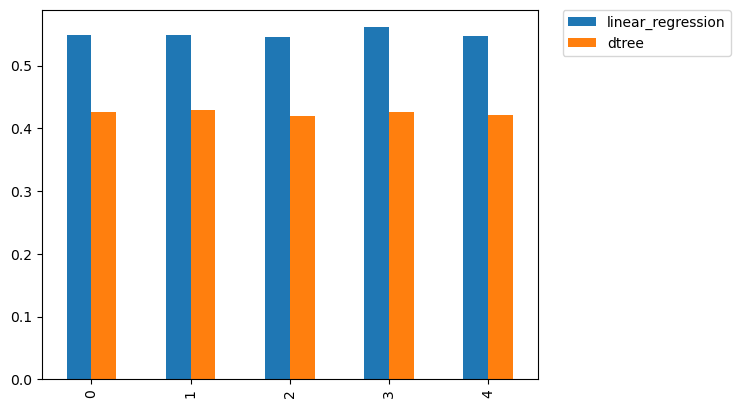

In [26]:
results_df.plot(y=["linear_regression", "dtree"], kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [27]:
from sklearn import tree

In [28]:
dtree = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)
dtree.fit(xtrain, ytrain)

DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)

In [40]:
pip install graphviz


Note: you may need to restart the kernel to use updated packages.


In [29]:
import graphviz

graphviz.set_jupyter_format('png')

'png'

In [30]:
decision_tree = tree.export_graphviz(dtree,out_file='tree.dot',feature_names=xtrain.columns,max_depth=2,filled=True)
!dot -Tpng tree.dot -o tree.png

'dot' is not recognized as an internal or external command,
operable program or batch file.
